# Web Mining Final Project
## Dalton J. Francis

How different are the receptions of blockbuster films between professional film critics and general audiences?
A python script implementing an http request module was written with the purpose of scraping the respective review pages for the films. The first three pages of both audience and critic reviews were pulled for analysis. BeautifulSoup was used for parsing the html, and the Natural Language Toolkit handled the language dissection.


pos list:  34
neg list:  22
avg pol:  0.11817833333333333
pos list:  36
neg list:  20
avg pol:  0.21464666666666657
pos list:  44
neg list:  11
avg pol:  0.3991066666666666
pos list:  28
neg list:  30
avg pol:  0.028326666666666674
pos list:  20
neg list:  32
avg pol:  -0.12163833333333332
pos list:  31
neg list:  26
avg pol:  0.059919999999999994


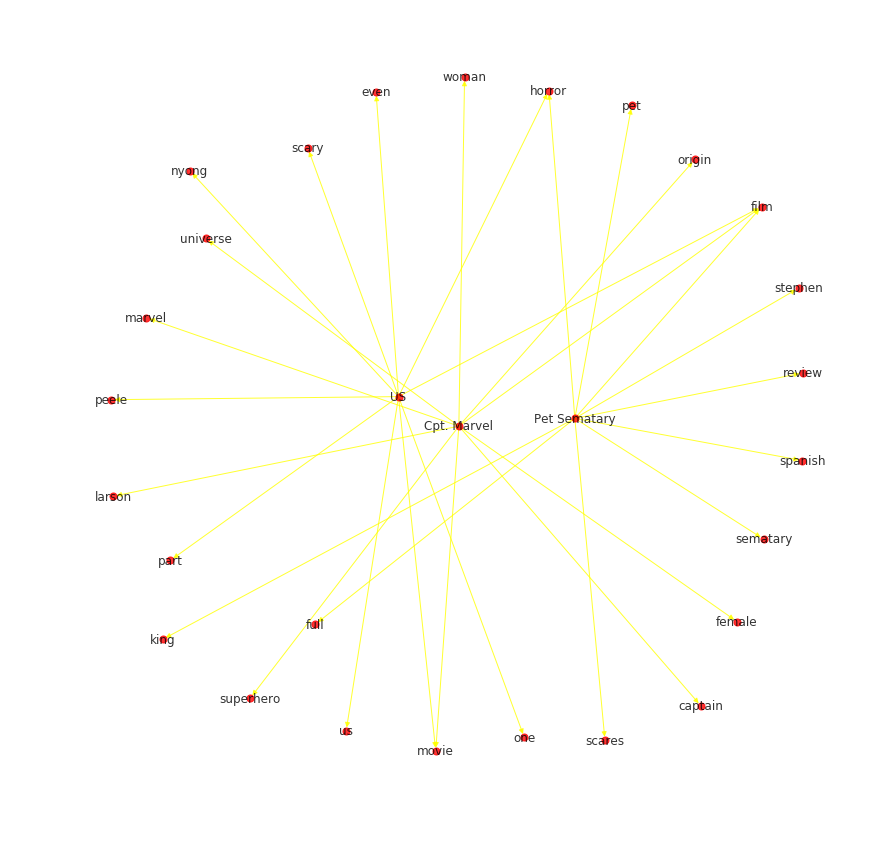

In [29]:
import pickle
import requests
from bs4 import BeautifulSoup
import nltk
import numpy
import matplotlib.pyplot as plt
import networkx as nx
from nl import score_sentences
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
##nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')


def tf(term,doc):
    tokens = doc.lower().split()
    return tokens.count(term.lower())
    
def pullReviews(url):
    tempCritReviews=[]
    tempCritSents=[]
    tempAudiReviews=[]
    tempAudiSents=[]
    for i in range(3):
        r = requests.get(url+'?page='+str(i+1)+'&sort=')
        soup = BeautifulSoup(r.text,'html5lib')
        divs = soup.findAll('div',{"class":"the_review"})
        for rev in divs:
            tempCritReviews.append(rev.text) ##4 pages of reviews, 20 reviews per page
            tempCritSents.extend(sent_tokenize(rev.text))
    for i in range(3):
        r = requests.get(url+'?page='+str(i+1)+'&type=user')
        soup = BeautifulSoup(r.text,'html5lib')
        divs = soup.findAll('div',{"class":"user_review"})
        for rev in divs:
            tempAudiReviews.append(rev.text) 
            tempAudiSents.extend(sent_tokenize(rev.text))
    return tempCritReviews,tempCritSents,tempAudiReviews,tempAudiSents

def vocabCheck(reviews):
    words = list()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stopwords.add("'s")
    stopwords.add("n't")
    stopwords.add("``")
    stopwords.add("...")
    stopwords.add("''")
    for i in reviews:
        words.extend(map(lambda x: x.lower(),nltk.tokenize.word_tokenize(i)))
    for punctuation in ",.'?''`:;’”“`]['-": #the last three are unicode characters of weird quotes. (python is unicode aware)
        stopwords.add(punctuation) #adds those individual punctuation to the stopwords to be filtered
    freqDist = nltk.FreqDist(words)
    sorted_terms = sorted(freqDist.items(), key=lambda x: x[1], reverse=True)
    tenMostCommon = [word[0] for word in sorted_terms if word[0] not in stopwords][:10]
    return tenMostCommon

def sentimentCheck(reviews):
    analyzer = SentimentIntensityAnalyzer()
    avgPolarity=0
    positiveReviews=[]
    negativeReviews=[]
    for review in reviews:
        if(analyzer.polarity_scores(review)['pos']>analyzer.polarity_scores(review)['neg']):
            positiveReviews.append(review)
            avgPolarity+=analyzer.polarity_scores(review)['compound'] #if review is mostly positive, add positive value
        elif(analyzer.polarity_scores(review)['pos']<analyzer.polarity_scores(review)['neg']):
            negativeReviews.append(review)
            avgPolarity+=analyzer.polarity_scores(review)['compound'] #if review is mostly negative, add the inverse of the negative value

    avgPolarity=avgPolarity/len(reviews) #any review with exact neutral values would just add 0.
    print('pos list: ',len(positiveReviews))
    print('neg list: ',len(negativeReviews))
    print('avg pol: ',avgPolarity)

def summarize(sentences, important_words, cthresh=5, top_sentences=5):
    scores = score_sentences(sentences,important_words)
    avg = numpy.mean(scores)
    std_dev = numpy.std(scores)
    score_threshold = avg + 0.5 * std_dev
    mean_scored = [t[0] for t in enumerate(scores) if t[1] > score_threshold]
    sorted_scores = sorted(enumerate(scores),key=lambda x: x[1],reverse=True)[:top_sentences]
    sorted_indices = sorted([s[0] for s in sorted_scores])
    return {'top-n': ' '.join([sentences[i] for i in sorted_indices]),'mean-score': ' '.join([sentences[i] for i in mean_scored])}

def graphCommon(filmNode, graph, important_words):
    for word in important_words:
        graph.add_node(word,type='word')
        graph.add_edge(filmNode,word,type='describes')
    
#criticReviews1,criticSents1,audienceReviews1,audienceSents1=pullReviews('https://www.rottentomatoes.com/m/captain_marvel/reviews/')
#with open('criticReviews1.pkl','wb') as f:
#    pickle.dump(criticReviews1,f)
#with open('criticSents1.pkl','wb') as f:
#    pickle.dump(criticSents1,f)
#with open('audienceReviews1.pkl','wb') as f:
#    pickle.dump(audienceReviews1,f)
#with open('audienceSents1.pkl','wb') as f:
#    pickle.dump(audienceSents1,f)

#criticReviews2,criticSents2,audienceReviews2,audienceSents2=pullReviews('https://www.rottentomatoes.com/m/pet_sematary_2019/reviews/')
#with open('criticReviews2.pkl','wb') as f:
#    pickle.dump(criticReviews2,f)
#with open('criticSents2.pkl','wb') as f:
#    pickle.dump(criticSents2,f)
#with open('audienceReviews2.pkl','wb') as f:
#    pickle.dump(audienceReviews2,f)
#with open('audienceSents2.pkl','wb') as f:
#    pickle.dump(audienceSents2,f)

#criticReviews,criticSents,audienceReviews,audienceSents=pullReviews('https://www.rottentomatoes.com/m/us_2019/reviews/')
#with open('criticReviews.pkl','wb') as f:
#    pickle.dump(criticReviews,f)
#with open('criticSents.pkl','wb') as f:
#    pickle.dump(criticSents,f)
#with open('audienceReviews.pkl','wb') as f:
#    pickle.dump(audienceReviews,f)
#with open('audienceSents.pkl','wb') as f:
#    pickle.dump(audienceSents,f)

with open('criticReviews.pkl','rb') as f:
    criticReviews = pickle.load(f)
with open('criticSents.pkl','rb') as f:
    criticSents = pickle.load(f)
with open('audienceReviews.pkl','rb') as f:
    audienceReviews = pickle.load(f)
with open('audienceSents.pkl','rb') as f:
    audienceSents = pickle.load(f)

with open('criticReviews1.pkl','rb') as f:
    criticReviews1 = pickle.load(f)
with open('criticSents1.pkl','rb') as f:
    criticSents1 = pickle.load(f)
with open('audienceReviews1.pkl','rb') as f:
    audienceReviews1 = pickle.load(f)
with open('audienceSents1.pkl','rb') as f:
    audienceSents1 = pickle.load(f)

with open('criticReviews2.pkl','rb') as f:
    criticReviews2 = pickle.load(f)
with open('criticSents2.pkl','rb') as f:
    criticSents2 = pickle.load(f)
with open('audienceReviews2.pkl','rb') as f:
    audienceReviews2 = pickle.load(f)
with open('audienceSents2.pkl','rb') as f:
    audienceSents2 = pickle.load(f)


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
commonWordsGraph = nx.DiGraph()
for i in range(3):
    if i == 0:
        commonWordsGraph.add_node('US',type='film')
        graphCommon('US',commonWordsGraph,vocabCheck(criticSents))
    if i == 1:
        commonWordsGraph.add_node('Cpt. Marvel',type='film')
        graphCommon('Cpt. Marvel',commonWordsGraph,vocabCheck(criticSents1))
    if i == 2:
        commonWordsGraph.add_node('Pet Sematary',type='film')
        graphCommon('Pet Sematary',commonWordsGraph,vocabCheck(criticSents2))
        
labels = {n:n for n in commonWordsGraph.nodes()}
nx.draw(commonWordsGraph,pos=nx.spring_layout(commonWordsGraph),arrows=True,ax=ax,node_size=50,edge_color='#ffff00',alpha=0.8,labels=labels,fonr_size=8)



sentimentCheck(criticReviews)
sentimentCheck(audienceReviews)
sentimentCheck(criticReviews1)
sentimentCheck(audienceReviews1)
sentimentCheck(criticReviews2)
sentimentCheck(audienceReviews2)
#vocabCheck(criticSents)
#vocabCheck(audienceReviews)
#sentimentCheck(criticReviews)
#sentimentCheck(audienceReviews)
#summarize(criticSents,vocabCheck(criticSents))
#summarize(audienceSents,vocabCheck(audienceSents))

According the website’s actual review scores, there is often a wide range of error between the total scores for films rated by unaccredited users compared to movie critics. The scoring system used by each of the critics is up to their own discretion, leaving room for confusion when reading them individually. Through lexical analysis of both pools of reviews, we show that the number of reviews that share mostly-positive sentiments is much closer than even the total ratings are. This removes the ambiguity of the scores given out by untrained reviewers by directly consulting the language they used within their review.